### 1.Imports 

In [26]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

### 2.Downloading Data

In [27]:
transform_flatten = transforms.Compose([
    transforms.ToTensor(),                  # Converts to tensor & normalizes to [0,1]
    transforms.Lambda(lambda x: x.view(-1)) # Flatten 28×28 → 784
])

transform_original = transforms.ToTensor()  # For CNN later → keep 28×28

train_dataset_f = datasets.MNIST(root='./data', train=True, transform=transform_flatten, download=True)
test_dataset_f  = datasets.MNIST(root='./data', train=False, transform=transform_flatten, download=True)

### 3. Splitting

In [28]:
idx = list(range(len(train_dataset_f)))

train_idx, temp_idx = train_test_split(idx, test_size=0.30, 
                                       stratify=train_dataset_f.targets)

val_idx, extra_test_idx = train_test_split(temp_idx, test_size=0.22,
                                          stratify=train_dataset_f.targets[temp_idx])

train_dataset = Subset(train_dataset_f , train_idx)
val_dataset   = Subset(train_dataset_f, val_idx)
extra_test_dataset = Subset(train_dataset_f, extra_test_idx)

test_dataset = ConcatDataset([test_dataset_f, extra_test_dataset])

### 4. Logistic Regression Implementation

4.1 Filter only 0,1

In [29]:
def filter_binary(dataset):
    binary_data = []
    binary_targets = []
    for x, y in dataset:
        if y in [0, 1]:
            binary_data.append(x)
            binary_targets.append(torch.tensor(y, dtype=torch.float32))
    return list(zip(binary_data, binary_targets))

train_binary = filter_binary(train_dataset)
val_binary = filter_binary(val_dataset)
test_binary = filter_binary(test_dataset)

train_loader = DataLoader(train_binary, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_binary, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_binary, batch_size=64, shuffle=False)


In [30]:
import torch

input_dim = 784

# Initialize weights and bias
W = torch.zeros((input_dim, 1))*0.01
b = torch.zeros(1)

# ✅ Manual implementation → we do gradient descent ourselves
W.requires_grad = False
b.requires_grad = False

# ✅ More stable sigmoid
def predict(X):
    z = X @ W + b
    return torch.sigmoid(z)


In [31]:
# ✅ Binary Cross Entropy Loss
def binary_cross_entropy(y_pred, y_true):
    # Clamp values to avoid log(0)
    eps = 1e-9
    y_pred = torch.clamp(y_pred, eps, 1 - eps)
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))

# ✅ Gradient Descent Update
def update_weights(X, y_true, y_pred, lr=0.01):
    m = X.shape[0]  # batch size
    error = y_pred - y_true  # (batch,1)

    # Compute gradients manually
    dW = (X.t() @ error) / m  # shape: [784,1]
    db = torch.mean(error)   # shape: scalar

    # Update parameters
    global W, b
    W -= lr * dW
    b -= lr * db


In [32]:
def accuracy(pred, labels):
    pred_labels = (pred >= 0.5).float()
    return (pred_labels == labels).float().mean().item()


num_epochs = 20
learning_rate = 0.01

train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("Starting Training...")

for epoch in range(num_epochs):

    # --- Training ---
    train_loss = 0.0
    train_acc = 0.0
    total_train = 0

    for X_batch, y_batch in train_loader:
        y_batch = y_batch.view(-1, 1)

        preds = predict(X_batch)
        loss = binary_cross_entropy(preds, y_batch)

        update_weights(X_batch, y_batch, preds, lr=learning_rate)

        train_loss += loss.item() * X_batch.size(0)
        train_acc += accuracy(preds, y_batch) * X_batch.size(0)
        total_train += X_batch.size(0)

    train_loss /= total_train
    train_acc /= total_train


    # --- Validation ---
    val_loss = 0.0
    val_acc = 0.0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_batch = y_batch.view(-1,1)

            preds = predict(X_batch)
            loss = binary_cross_entropy(preds, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            val_acc += accuracy(preds, y_batch) * X_batch.size(0)
            total_val += X_batch.size(0)

    val_loss /= total_val
    val_acc /= total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch + 1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Starting Training...
Epoch 1/20 | Train Loss: 0.2124, Train Acc: 0.9926 | Val Loss: 0.0962, Val Acc: 0.9949
Epoch 2/20 | Train Loss: 0.0696, Train Acc: 0.9971 | Val Loss: 0.0580, Val Acc: 0.9949
Epoch 3/20 | Train Loss: 0.0464, Train Acc: 0.9974 | Val Loss: 0.0439, Val Acc: 0.9949
Epoch 4/20 | Train Loss: 0.0361, Train Acc: 0.9974 | Val Loss: 0.0364, Val Acc: 0.9949
Epoch 5/20 | Train Loss: 0.0302, Train Acc: 0.9977 | Val Loss: 0.0317, Val Acc: 0.9949
Epoch 6/20 | Train Loss: 0.0262, Train Acc: 0.9979 | Val Loss: 0.0284, Val Acc: 0.9953
Epoch 7/20 | Train Loss: 0.0234, Train Acc: 0.9979 | Val Loss: 0.0259, Val Acc: 0.9956
Epoch 8/20 | Train Loss: 0.0213, Train Acc: 0.9977 | Val Loss: 0.0240, Val Acc: 0.9956
Epoch 9/20 | Train Loss: 0.0196, Train Acc: 0.9979 | Val Loss: 0.0225, Val Acc: 0.9956
Epoch 10/20 | Train Loss: 0.0182, Train Acc: 0.9980 | Val Loss: 0.0213, Val Acc: 0.9956
Epoch 11/20 | Train Loss: 0.0171, Train Acc: 0.9979 | Val Loss: 0.0203, Val Acc: 0.9960
Epoch 12/20 | Train 

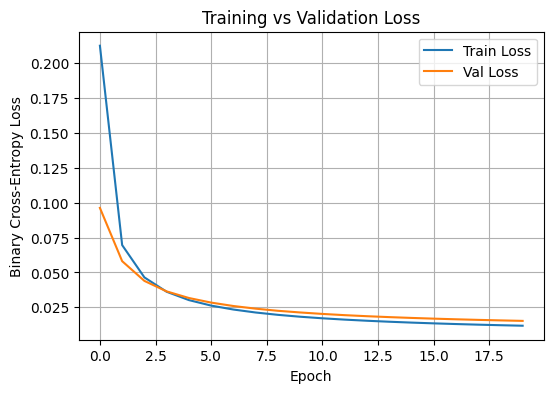

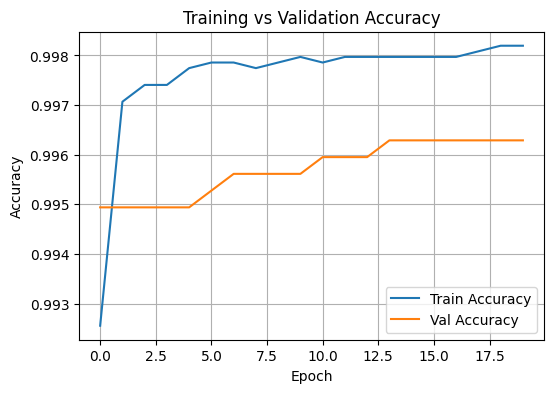

🎯 Final Test Accuracy: 0.9986 (99.86%)


<Figure size 600x500 with 0 Axes>

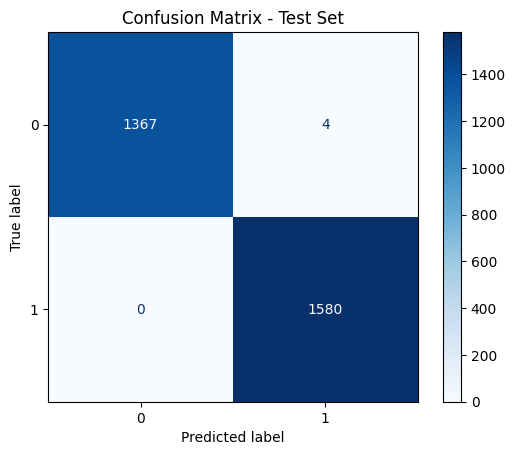


📊 Detailed Classification Report:
Confusion Matrix:
True Negatives (0 correctly classified): 1367
False Positives (0 misclassified as 1): 4
False Negatives (1 misclassified as 0): 0
True Positives (1 correctly classified): 1580

📈 Additional Metrics:
Precision: 0.9975
Recall: 1.0000
F1-Score: 0.9987

🏁 TRAINING SUMMARY:
Final Training Accuracy: 0.9982
Final Validation Accuracy: 0.9963
Final Test Accuracy: 0.9986
Final Training Loss: 0.0118
Final Validation Loss: 0.0153


In [33]:

# 1. 📊 Loss Curves
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# 2. 📊 Accuracy Curves
plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 3. 🧪 Final Test Accuracy and Confusion Matrix
def evaluate_model(test_loader):
    all_preds = []
    all_labels = []
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.float().view(-1, 1)
            preds = predict(X_batch)
            
            # Convert probabilities to binary predictions
            pred_labels = (preds >= 0.5).float()
            
            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            
            test_correct += (pred_labels == y_batch).sum().item()
            test_total += y_batch.size(0)
    
    test_accuracy = test_correct / test_total
    return test_accuracy, np.array(all_preds), np.array(all_labels)

# Evaluate on test set
test_accuracy, test_preds, test_labels = evaluate_model(test_loader)

print(f"🎯 Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# 4. 📋 Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Print detailed classification report
print("\n📊 Detailed Classification Report:")
print(f"Confusion Matrix:")
print(f"True Negatives (0 correctly classified): {cm[0, 0]}")
print(f"False Positives (0 misclassified as 1): {cm[0, 1]}")
print(f"False Negatives (1 misclassified as 0): {cm[1, 0]}")
print(f"True Positives (1 correctly classified): {cm[1, 1]}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📈 Additional Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# 5. 📈 Final Training Summary
print(f"\n🏁 TRAINING SUMMARY:")
print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
